In [223]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [82]:
from impala.dbapi import connect
from impala.util import as_pandas
import re 
#get data
def get_data(sql):
    conn = connect(host = '10.1.169.3',port = 10000, auth_mechanism = 'PLAIN')
    cursor = conn.cursor()
    cursor.execute(sql)
    df = as_pandas(cursor)
    return df

In [180]:
df_flag = get_data('select * from tmp.cebai_imei_flag_20170101_20170601')
print(len(df_flag))

1210659


In [184]:
y = pd.read_csv('getui_app_unistl_test1_y.txt',sep=r"\s+")

In [188]:
print(y.head(5))

                aid              uid       imei apply_time  y
23654162   85842482  861404030391033  2017/3/15      23:58  0
23654353  103971933  860778030179774  2017/3/15      23:53  0
23566483  103771526  868809027435879  2017/3/15      23:51  0
23652982  104042520  862458037057194  2017/3/15      23:45  0
23653654   95771628  865568027852532  2017/3/15      23:42  1


In [312]:
df = pd.read_csv('data_imei_select.txt',sep=r"\s+")
print(len(df))

3092


In [61]:
APP_NAME = pd.read_csv('app_name.txt',sep=r"\s+",encoding='iso-8859-1')

In [96]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns

In [118]:
df_dropna_1 = df[df['app_num'] != -999]
print(len(df_dropna))

2542


In [54]:
def split_app(app_str):
    app_list = app_str.split('/')
    all_app = pd.read_csv('app_name.txt',sep=r"\s+",encoding='iso-8859-1')['code'].tolist()
    app_num = len(all_app)
    one_row_feature = np.zeros(app_num,dtype = int)
    for index_app in range(app_num):
        if str(all_app[index_app]) in app_list:
            one_row_feature[index_app] = 1
    return one_row_feature

In [167]:
df_new = df.copy()
new_index = df_new.index
df_new[APP_NAME['http'].tolist()] = pd.DataFrame([split_app(x) for x in df_new['app_str'].tolist()],index = new_index)
del df_new['app_str']

In [333]:
y.drop_duplicates(['uid'],inplace = True)
print(len(y))

14975


In [336]:
df_combine = pd.merge(df_new, y, how='left', left_on='imei', right_on='uid')
#df_combine.drop_duplicates(['imei_x'],inplace = True)
df_combine.drop(['imei_x','aid','uid','imei_y','apply_time'],axis=1, inplace=True)

In [203]:
def show_hist(array,bins):
    plt.hist(array,bins =bins)
    plt.title("Gaussian Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    #plt.axis([40, 160, 0, 0.03])
    plt.grid(True)
    plt.show()
def show_histogram

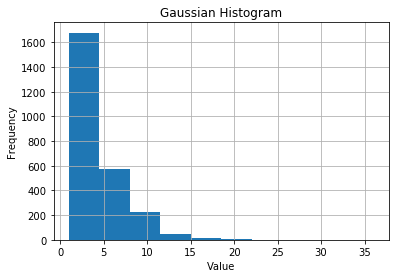

In [206]:
show_hist(df_combine[df_combine['app_num']>=0]['app_num'].tolist(),10)

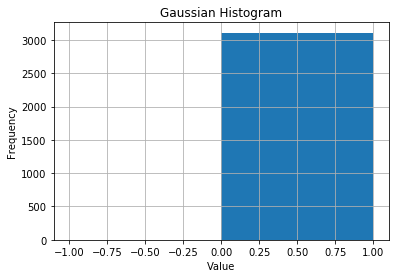

In [300]:
show_hist(df_combine['cn.com.hakim.dingjidai'].tolist(),[-1,0,1])

In [302]:
def get_good_bad_num(df):
    #?! size and len
    good_num = len(df[df['y'] == 0])
    bad_num = len(df[df['y'] == 1])
    return float(good_num),float(bad_num)
def get_woe(df,colname,p,q):
    df = df.apply(pd.to_numeric,errors='ignore')
    total_good,total_bad = get_good_bad_num(df)
    df_p_q = df[(df[colname]>p) & (df[colname]<=q)]
    good,bad = get_good_bad_num(df_p_q)
    if good == 0:
        good = 1
        print('%s good is 0'% colname)
    if bad == 0:
        bad = 1
        print('%s bad is 0'% colname)
    obs = good + bad
    bad_rate = bad/obs
    pop = (good+bad)/(total_good+total_bad)
    woe = math.log((bad/total_bad)/(good/total_good))
    iv = (bad/total_bad-good/total_good)*woe
    return obs,bad,woe,bad_rate,pop,iv
def get_woe_list(df,colname,cuts):
    woe_list =[]
    for i in range(len(cuts)-1):
        obs,bad,woe,bad_rate,pop,iv = get_woe(df,colname,cuts[i],cuts[i+1])
        temp = [cuts[i],cuts[i+1],obs,bad,woe,bad_rate,pop,iv]
        woe_list.append(temp)
    df_woe_list = pd.DataFrame(woe_list,columns=['start','end','obs','bad','woe','badrate','pop','iv'])
    return df_woe_list

In [260]:
def counts_col(train_df):
    unique_values_dict = {}
    for col in train_df.columns:
        if col not in ["app_num", "y"]:
            unique_value = str(np.sort(train_df[col].unique()).tolist())
            tlist = unique_values_dict.get(unique_value, [])
            tlist.append(col)
            unique_values_dict[unique_value] = tlist[:]
    for unique_val, columns in unique_values_dict.items():
        #print("Columns containing the unique values : ",type(unique_val))
        #print(columns)
        #print("--------------------------------------------------")
        if (len(unique_val) == 3):
            one_value = columns
        elif(len(unique_val) == 6):
            two_value = columns
    return one_value,two_value


In [338]:
one_value_col,two_value_col = counts_col(df_combine)

In [339]:
colname = 'app_num'
cuts = [-float('Inf'),0,2,4,float('Inf')]
woe = get_woe_list(df_combine,colname,cuts)
print(np.sum(woe['iv'].tolist()))
print(woe)
woe.to_csv('app_num.csv')

0.0219351214223
      start       end    obs   bad       woe   badrate       pop        iv
0      -inf  0.000000  550.0  23.0 -0.287481  0.041818  0.177878  0.012954
1  0.000000  2.000000  965.0  51.0 -0.041780  0.052850  0.312096  0.000535
2  2.000000  4.000000  704.0  40.0  0.034822  0.056818  0.227684  0.000280
3  4.000000       inf  873.0  56.0  0.163938  0.064147  0.282342  0.008166


In [308]:
def get_iv(df):
    cuts = [-1,0,1]
    out = []
    for colname in two_value_col:
        try:
            woe = get_woe_list(df_combine,colname,cuts) 
            iv = np.sum(woe['iv'].tolist())
            obs = woe['obs'].tolist()
            bad = woe['bad'].tolist()
            good = np.array(obs) - np.array(bad)
            bad_0 = bad[0]
            good_0 = good[0]
            bad_1 = bad[1]
            good_1 = good[1]
            temp = [colname,iv,bad_0,good_0,bad_1,good_1]
            out.append(temp)
        except Exception as e :
            print(colname+'---------' ,e)
    out = pd.DataFrame(out)
    out.to_csv('iv.csv')
    return out

In [369]:
#RF_tarin
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plot
import numpy as np
from math import sqrt,fabs,exp
def train_online(df):
    X = df.drop(['y'],axis = 1)
    y = df['y']
    xTrain,xTest,yTrain,yTest = train_test_split(X.values,y.values.ravel(),test_size = 0.2,random_state = 520)
    rf = ensemble.RandomForestClassifier(n_estimators=40,max_depth=3,oob_score = True,random_state = 531,class_weight = 'auto')
    rf.fit(xTrain,yTrain)
    print("online----------oob_score:%f" % rf.oob_score_)
    prediction = rf.predict_proba(xTest)
    auc = roc_auc_score(yTest,prediction[:,1:2])
    print ("online-------AUC Score (test):%f" % auc)
    return rf

In [361]:
#grid search
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn import cross_validation, metrics
def grid_search(df):
    X = df.drop(['y'],axis = 1)
    y = df['y']
    X,y  = X.values,y.values.ravel()
    param_test1 = {'n_estimators':np.linspace(10,100,10,dtype = int),'max_depth':np.linspace(1,11,5,dtype = int)}
    gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state=531,n_jobs=-1), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
    gsearch1.fit(X,y)
    print(gsearch1.grid_scores_)
    print('***********************')
    print(gsearch1.best_params_)
    print('***********************')
    print(gsearch1.best_score_)

In [379]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
from time import clock
start=clock()
with tf.device("/gpu:0"):
    grid_search(df_combine)
finish=clock()
print( (finish-start)/1000000)

[mean: 0.46821, std: 0.03823, params: {'max_depth': 1, 'n_estimators': 10}, mean: 0.48362, std: 0.04504, params: {'max_depth': 1, 'n_estimators': 20}, mean: 0.49232, std: 0.03594, params: {'max_depth': 1, 'n_estimators': 30}, mean: 0.50346, std: 0.04562, params: {'max_depth': 1, 'n_estimators': 40}, mean: 0.52082, std: 0.03429, params: {'max_depth': 1, 'n_estimators': 50}, mean: 0.51697, std: 0.03168, params: {'max_depth': 1, 'n_estimators': 60}, mean: 0.52120, std: 0.04429, params: {'max_depth': 1, 'n_estimators': 70}, mean: 0.52387, std: 0.04788, params: {'max_depth': 1, 'n_estimators': 80}, mean: 0.52585, std: 0.04907, params: {'max_depth': 1, 'n_estimators': 90}, mean: 0.52505, std: 0.04357, params: {'max_depth': 1, 'n_estimators': 100}, mean: 0.52566, std: 0.03492, params: {'max_depth': 3, 'n_estimators': 10}, mean: 0.53745, std: 0.03228, params: {'max_depth': 3, 'n_estimators': 20}, mean: 0.54620, std: 0.04633, params: {'max_depth': 3, 'n_estimators': 30}, mean: 0.56267, std: 0.0

/data/program/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [370]:
rf = train_online(df_combine)

online----------oob_score:0.852810
online-------AUC Score (test):0.536601


In [352]:
import numpy as np
import pandas as pd
from collections import Counter
def ks_value(pred,true,n):
    score = (1.-pred)*1000
    index = score.argsort()
    score_sort = np.sort(score)
    true_sort = true[index]
    len_num = pred.size
    add = int(len_num/n)
    out = []
    for i in get_split_len(len_num,n):
        if i == get_split_len(len_num,n)[-1]:
            good_num,bad_num,total = get_good_bad(true_sort,i,-1)
            min_value,max_value = get_max_min(score_sort,i,-1)
            temp = [min_value,max_value,total,bad_num,good_num]
        else:
            good_num,bad_num,total = get_good_bad(true_sort,i,i+add)
            min_value,max_value = get_max_min(score_sort,i,i+add)
            temp = [min_value,max_value,total,bad_num,good_num]
        out.append(temp)
    return out
def list_to_dataframe(out):
    df = pd.DataFrame.from_records(out,columns = ["min_value","max_value","total","bad_num","good_num"])
    return df
def get_good_bad(true,startindex,endindex):
    if endindex == -1:
        true_index = true[startindex:]
    else:
        true_index = true[startindex:endindex]
    c = Counter([i for i in true_index])
    total = true_index.size
    return c[0],c[1],total
def get_max_min(pred,startindex,endindex):
    return pred[startindex],pred[endindex]
def get_split_len(len_num,n):
    out = [0]
    add = int(len_num/n)
    index = 0
    for i in range(n-1):
        index += add
        out.append(int(index))
    return out
def get_ksvalue_offline(rf,df,name):
    X = df.drop(['y'],axis = 1)
    y = df['y']
    xTest,yTest = X.values,y.values.ravel()
    prediction = rf.predict_proba(xTest)
    pred = prediction[:,1:2].ravel()
    out = ks_value(pred,yTest,10)
    df = list_to_dataframe(out)
    df.to_csv(name)
    return df

In [371]:
get_ksvalue_offline(rf,df_combine,'ks.csv')

,min_value,max_value,total,bad_num,good_num
0,393.032395,501.525026,309,53,256
1,501.525026,514.450833,309,18,291
2,514.450833,518.674861,309,14,295
3,518.674861,518.674861,309,11,298
4,518.674861,518.674861,309,18,291
5,518.674861,521.320925,309,17,292
6,521.320925,521.320925,309,15,294
7,521.320925,528.931452,309,9,300
8,528.931452,545.607815,309,5,304
9,545.607815,733.360958,311,10,301
